## 1. Imports and setup

In [1]:
%%capture
#@title
!pip install tensorflow_addons

import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientnetv2" not in os.getcwd():
    !git clone --depth 1 https://github.com/google/automl
    os.chdir('automl/efficientnetv2')
    sys.path.append('.')
else:
    !git pull

def download(m):
    if m not in os.listdir():
        !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/{m}.tgz
        !tar zxf {m}.tgz
    ckpt_path = os.path.join(os.getcwd(), m)
    return ckpt_path

In [2]:
import tensorflow_hub as hub
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import csv

### Parameters

In [78]:
model_name = 'efficientnetv2-b0' #@param {type:'string'}
ckpt_type = '1k'   # @param ['21k', '21k-ft1k', '1k']
batch_size =  4   #@param {type:"integer"}
image_size = 223

## 2. WikiArt Data

In [11]:
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [61]:
data_dir_train = '/projectnb/dl523/students/nannkat/EC520/wikipaintings_train'
data_dir_val = '/projectnb/dl523/students/nannkat/EC520/wikipaintings_val'
data_dir_test = '/projectnb/dl523/students/nannkat/EC520/wikipaintings_test'

### Load data into data generator objects

In [50]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
datagen_kwargs2 = dict(rescale=1./255)

dataflow_kwargs = dict(target_size=(image_size, image_size),
                       batch_size=batch_size,
                       interpolation="bilinear")

#valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
   # **datagen_kwargs)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs2)

#valid_generator = valid_datagen.flow_from_directory(
#    data_dir_train, subset="validation", shuffle=False, **dataflow_kwargs)

valid_generator = valid_datagen.flow_from_directory(
    data_dir_val, shuffle=False, **dataflow_kwargs)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
          rotation_range=40,
          horizontal_flip=True,
          width_shift_range=0.2, height_shift_range=0.2,
          shear_range=0.2, zoom_range=0.2,
          **datagen_kwargs)
else:
    train_datagen = valid_datagen

#train_generator = train_datagen.flow_from_directory(
#    data_dir_train, subset="training", shuffle=True, **dataflow_kwargs)

train_generator = train_datagen.flow_from_directory(
    data_dir_train, shuffle=True, **dataflow_kwargs)

Found 250 images belonging to 25 classes.
Found 250 images belonging to 25 classes.


In [63]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    data_dir_test, shuffle=False, **dataflow_kwargs)

Found 250 images belonging to 25 classes.


### Visualize input

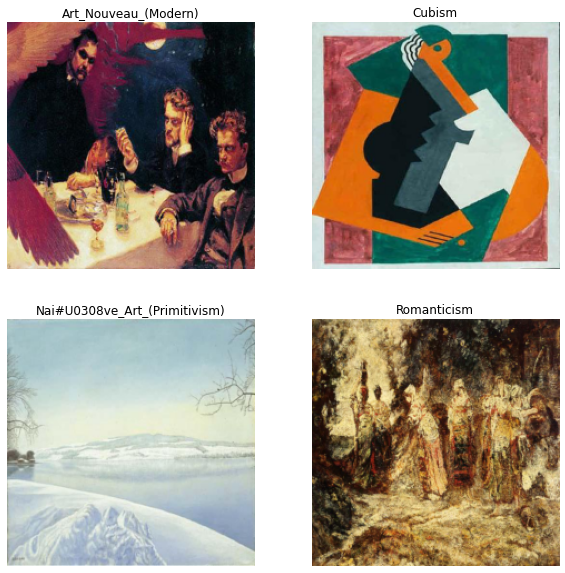

In [80]:
import matplotlib.pyplot as plt

def get_class_string_from_index(index):
    for class_string, class_index in valid_generator.class_indices.items():
        if class_index == index:
            return class_string

plt.figure(figsize=(10, 10))

for i in range(batch_size):
    image, label = next(train_generator)
    image = image[0, :, :, :]
    index = np.argmax(label[0])
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.title(get_class_string_from_index(index))
    plt.axis("off")

## 3. Load Efficientnet v2 and Checkpoint

Checkpoints available:
 - 'efficientnetv2-s'
 - 'efficientnetv2-m'
 - 'efficientnetv2-l'
 - 'efficientnetv2-xl'
 - 'efficientnetv2-b0'
 - 'efficientnetv2-b1'
 - 'efficientnetv2-b2'
 - 'efficientnetv2-b3'

### Model with fine tuning

They say they have this argument for whether to finetune the whole model (do_fine_tuning = True) or just the top layer (do_fine_tuning = False). I tried both. When I print out the model it says the same number of parameters is trainable though so Im not 100% sure there is any difference

In [51]:
import effnetv2_model

In [52]:
do_fine_tuning = True
image_size = 223

tf.keras.backend.clear_session()
model1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[image_size, image_size, 3]),
    effnetv2_model.get_model('efficientnetv2-b0', include_top=False, training = do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax'),
])
model1.build((None, image_size, image_size, 3))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetv2-b0 (EffNetV2M (None, 1280)              5919312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 25)                32025     
Total params: 5,951,337
Trainable params: 5,890,729
Non-trainable params: 60,608
_________________________________________________________________


### Model without fine tuning

In [35]:
do_fine_tuning = False
image_size = 223

tf.keras.backend.clear_session()
model2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[image_size, image_size, 3]),
    effnetv2_model.get_model('efficientnetv2-b0', include_top=False, training = do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax'),
])
model2.build((None, image_size, image_size, 3))
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetv2-b0 (EffNetV2M (None, 1280)              5919312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 25)                32025     
Total params: 5,951,337
Trainable params: 5,890,729
Non-trainable params: 60,608
_________________________________________________________________


## 4.Transfer Learning

In [53]:
num_epochs = 20 #@param {type:"integer"}

### Model 1 with finetuning = true

In [54]:
model1.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [55]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model1.fit(train_generator, epochs = num_epochs, validation_data = valid_generator, steps_per_epoch=steps_per_epoch,\
                 validation_steps=validation_steps).history

Epoch 1/20
62/62 [==============================] - 13s 209ms/step - loss: 3.2184 - accuracy: 0.0366 - val_loss: 3.2187 - val_accuracy: 0.0565
Epoch 2/20
62/62 [==============================] - 8s 128ms/step - loss: 3.2170 - accuracy: 0.0325 - val_loss: 3.2180 - val_accuracy: 0.0726
Epoch 3/20
62/62 [==============================] - 8s 128ms/step - loss: 3.2157 - accuracy: 0.0569 - val_loss: 3.2174 - val_accuracy: 0.0685
Epoch 4/20
62/62 [==============================] - 8s 128ms/step - loss: 3.2132 - accuracy: 0.0610 - val_loss: 3.2167 - val_accuracy: 0.0766
Epoch 5/20
62/62 [==============================] - 8s 127ms/step - loss: 3.2092 - accuracy: 0.1382 - val_loss: 3.2158 - val_accuracy: 0.1129
Epoch 6/20
62/62 [==============================] - 8s 128ms/step - loss: 3.2078 - accuracy: 0.1341 - val_loss: 3.2152 - val_accuracy: 0.1008
Epoch 7/20
62/62 [==============================] - 8s 124ms/step - loss: 3.2063 - accuracy: 0.1463 - val_loss: 3.2146 - val_accuracy: 0.0806
Epoch

### Model 2 with finetuning = false

In [56]:
model2.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [58]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model2.fit(train_generator, epochs = num_epochs, validation_data = valid_generator, steps_per_epoch=steps_per_epoch,\
                 validation_steps=validation_steps).history

Epoch 1/20
62/62 [==============================] - 8s 133ms/step - loss: 3.2204 - accuracy: 0.0285 - val_loss: 3.2189 - val_accuracy: 0.0403
Epoch 2/20
62/62 [==============================] - 7s 119ms/step - loss: 3.2159 - accuracy: 0.0488 - val_loss: 3.2182 - val_accuracy: 0.0484
Epoch 3/20
62/62 [==============================] - 7s 118ms/step - loss: 3.2130 - accuracy: 0.1179 - val_loss: 3.2178 - val_accuracy: 0.0524
Epoch 4/20
62/62 [==============================] - 7s 116ms/step - loss: 3.2133 - accuracy: 0.1138 - val_loss: 3.2173 - val_accuracy: 0.0726
Epoch 5/20
62/62 [==============================] - 7s 116ms/step - loss: 3.2103 - accuracy: 0.1057 - val_loss: 3.2167 - val_accuracy: 0.0565
Epoch 6/20
62/62 [==============================] - 7s 117ms/step - loss: 3.2081 - accuracy: 0.1545 - val_loss: 3.2155 - val_accuracy: 0.0605
Epoch 7/20
62/62 [==============================] - 7s 116ms/step - loss: 3.2052 - accuracy: 0.1748 - val_loss: 3.2148 - val_accuracy: 0.0887
Epoch 

## 5. Test/display results

### Display example result

(4, 223, 223, 3)


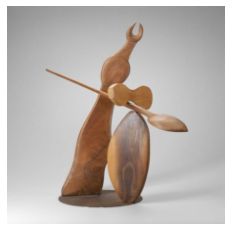

True label: Abstract_Art
Predicted label: Minimalism


In [84]:
def get_class_string_from_index(index):
    for class_string, class_index in valid_generator.class_indices.items():
        if class_index == index:
            return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model1.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

### Evaluate

In [65]:
test_steps = test_generator.samples // test_generator.batch_size
model1.evaluate(test_generator, steps = test_steps)

62/62 [==============================] - 4s 58ms/step - loss: 3.1824 - accuracy: 0.1532


[3.182370901107788, 0.15322580933570862]

### Predict

In [66]:
preds = model1.predict(test_generator, steps = test_steps)
print("predictions shape:", preds.shape)

predictions shape: (248, 25)


### Predict into .csv

In [108]:
preds = []
true_labels = []

In [109]:
for batch in range(len(test_generator)):
    images, labels = test_generator.next()
    #print('On batch no: {}'.format(i))
    for i in range(len(images)):
        image = images[i, :, :, :]
        label = np.argmax(labels[i])
        prediction_scores = model1.predict(np.expand_dims(image, axis=0))
        pred = np.argmax(prediction_scores)
        preds.append(pred)
        true_labels.append(label)
        

In [112]:
print(len(preds))
print(len(true_labels))

250
250


In [115]:
print(true_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [116]:
print(preds)

[2, 0, 13, 0, 5, 13, 13, 5, 13, 13, 13, 5, 13, 0, 13, 8, 0, 2, 13, 13, 2, 2, 5, 0, 13, 13, 23, 0, 13, 13, 23, 21, 15, 5, 15, 15, 13, 8, 23, 13, 4, 4, 4, 4, 13, 13, 5, 8, 4, 4, 13, 13, 13, 5, 5, 13, 13, 13, 13, 13, 0, 11, 13, 5, 13, 10, 23, 0, 13, 18, 23, 23, 23, 13, 23, 23, 13, 8, 0, 15, 10, 23, 23, 23, 23, 13, 13, 21, 4, 13, 13, 15, 15, 4, 4, 21, 4, 13, 15, 4, 13, 13, 15, 13, 21, 2, 4, 13, 21, 4, 2, 0, 13, 4, 2, 13, 2, 5, 13, 13, 0, 13, 4, 15, 23, 4, 4, 13, 4, 4, 13, 13, 13, 13, 0, 0, 13, 0, 13, 13, 19, 13, 17, 13, 13, 14, 10, 3, 15, 0, 15, 15, 15, 15, 15, 15, 4, 23, 13, 15, 15, 4, 15, 13, 5, 21, 13, 15, 1, 13, 17, 0, 8, 13, 0, 0, 2, 8, 12, 8, 13, 2, 4, 13, 8, 23, 13, 8, 21, 2, 13, 13, 21, 15, 4, 4, 14, 4, 4, 2, 8, 15, 13, 15, 4, 4, 4, 21, 15, 4, 4, 21, 13, 21, 13, 15, 2, 4, 15, 15, 15, 8, 8, 10, 2, 8, 18, 8, 23, 8, 7, 2, 15, 23, 13, 21, 9, 13, 8, 8, 24, 24, 13, 13, 8, 8, 0, 8, 24, 8]


In [122]:
#check if it matches calculated accuracy
correct = 0
for i in range(len(preds)):
    if preds[i] == true_labels[i]:
        correct += 1

acc = correct/len(preds)
print(acc)

0.136


In [113]:
import pandas as pd
preds_df = pd.DataFrame(list(zip(preds, true_labels)),
               columns =['Prediction', 'True Label'])

In [114]:
preds_df.head()

,Prediction,True Label
0,2,0
1,0,0
2,13,0
3,0,0
4,5,0


In [118]:
preds_df.to_csv('/projectnb/dl523/students/nannkat/EC520/preds_vs_true_effnet.csv', index=False, header = False)

## 6. Appendix - Alternative way to read in image data

In [81]:
wikiart_train = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels = 'inferred',\
                                                                    label_mode = 'int', \
                                                                    batch_size = batch_size, image_size = (image_size, image_size),\
                                                                    shuffle = True, seed = 123
                                                                   )

wikiart_val = tf.keras.preprocessing.image_dataset_from_directory('/projectnb/dl523/students/nannkat/EC520/wikipaintings_val', labels = 'inferred',\
                                                                    label_mode = 'int', \
                                                                    batch_size = batch_size, image_size = (image_size, image_size),\
                                                                    shuffle = True, seed = 123, validation_split = 0.2,\
                                                                  subset = 'validation'
                                                                   )

Found 250 files belonging to 25 classes.
Found 250 files belonging to 25 classes.
Using 50 files for validation.


In [82]:
class_names = wikiart_train.class_names
print(class_names)
num_classes = len(wikiart_train.class_names)

['Abstract_Art', 'Abstract_Expressionism', 'Art_Informel', 'Art_Nouveau_(Modern)', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Early_Renaissance', 'Expressionism', 'High_Renaissance', 'Impressionism', 'Magic_Realism', 'Mannerism_(Late_Renaissance)', 'Minimalism', 'Naïve_Art_(Primitivism)', 'Neoclassicism', 'Northern_Renaissance', 'Pop_Art', 'Post-Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Surrealism', 'Symbolism', 'Ukiyo-e']


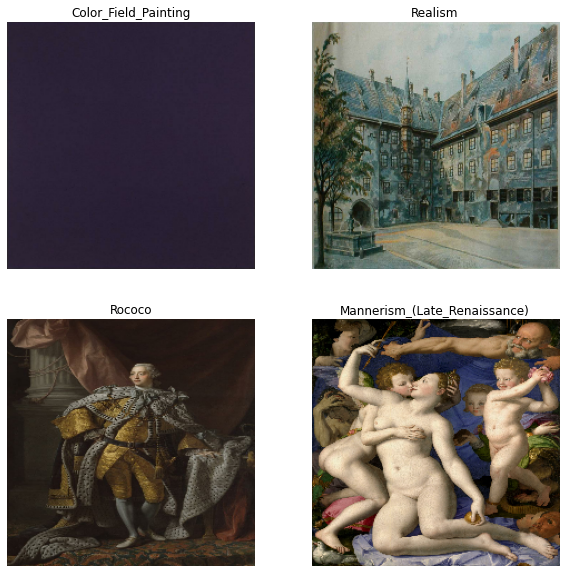

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in wikiart_train.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")